<h1><big><center>Object recognition and computer vision 2018/2019</center></big></h1>

<h3><big><center><a href="http://www.di.ens.fr/~ponce/">Jean Ponce</a>, <a href="http://www.di.ens.fr/~laptev/">Ivan Laptev</a>, <a href="http://lear.inrialpes.fr/~schmid/">Cordelia Schmid</a> and <a href="http://www.di.ens.fr/~josef/">Josef Sivic</a></center></big></h3>


<h2><big><center> Assignment 1: Instance-level recognition</center></big></h2>

<h5><big><center>Adapted from practicals from <a href="http://www.robots.ox.ac.uk/~vgg/practicals/overview/index.html">Andrea Vedaldi and Andrew Zisserman</a> 
  <br>by <a href="https://www.di.ens.fr/~varol/">Gul Varol</a> and <a href="https://www.di.ens.fr/~iroccosp/">Ignacio Rocco</a></center></big></h5>

</br>
<p align="center">
<img height=300px src="http://www.di.ens.fr/willow/teaching/recvis17/assignment1/images/image12.png"/></p>
<p align="center"></p>

**STUDENT**:  VINCENT Louis

**EMAIL**:  louisjvincentgmail.com

# Guidelines

The purpose of this assignment is that you get hands-on experience with the topics covered in class, which will help you understand these topics better. Therefore, ** it is imperative that you do this assignment yourself. No code sharing will be tolerated. **

Once you have completed the assignment, you will submit the `ipynb` file containing **both** code and results. For this, make sure to **run your notebook completely before submitting**.

The `ipynb` must be named using the following format: **A1_LASTNAME_Firstname.ipynb**, and submitted in the **class Moodle page**.

# Goal
The goal of instance-level recognition is to match (recognize) a specific object or scene.  Examples include recognizing a specific building, such as Notre Dame, or a specific painting, such as `Starry Night’ by Van Gogh. The object is recognized despite changes in scale, camera viewpoint, illumination conditions and partial occlusion. An important application is image retrieval - starting from an image of an object of interest (the query), search  through an image dataset to obtain (or retrieve) those images that contain the target object.

The goal of this assignment is to experiment and get basic practical experience with the methods that enable specific object recognition. It includes: (i) using SIFT features to obtain sparse matches between two images; (ii) using similarity co-variant detectors to cover changes in viewpoint; (iii) vector quantizing the SIFT descriptors into visual words to enable large scale retrieval; and (iv) constructing and using an image retrieval system to identify objects.

# Setup environment

## Download and install CyVLFeat

In [1]:
!wget -N http://www.di.ens.fr/willow/teaching/recvis/assignment1/install_cyvlfeat.py
%run install_cyvlfeat.py

--2018-10-23 13:49:02--  http://www.di.ens.fr/willow/teaching/recvis/assignment1/install_cyvlfeat.py
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/willow/teaching/recvis/assignment1/install_cyvlfeat.py [following]
--2018-10-23 13:49:02--  https://www.di.ens.fr/willow/teaching/recvis/assignment1/install_cyvlfeat.py
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘install_cyvlfeat.py’ not modified on server. Omitting download.

installing cython... done!
building cyvlfeat... done!
installing cyvlfeat... done! NOTE: to uninstall run: cat cyvlfeat_files.txt | xargs rm -rf
copying vlfeat dynamic libary to a reachable location... done!
Installation of cyvlfeat is finished


## Imports

In [0]:
import cyvlfeat
import numpy as np
from scipy.misc import imread,imresize,imrotate
from urllib.request import urlopen
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
from cyvlfeat.plot import plotframes
from scipy.io import loadmat
import numpy as np

# change some default matplotlib parameters
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.dpi'] = 120

# ignore warnings
warnings.filterwarnings('ignore')

## Download and uncompress data

In [3]:
print('downloading assignment images...')
!wget -c http://www.di.ens.fr/willow/teaching/recvis/assignment1/A1_images.tar.gz
print('done!')
print('uncompressing...')
!tar -xzf A1_images.tar.gz
print('done!')

downloading assignment images...
--2018-10-23 13:49:11--  http://www.di.ens.fr/willow/teaching/recvis/assignment1/A1_images.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/willow/teaching/recvis/assignment1/A1_images.tar.gz [following]
--2018-10-23 13:49:12--  https://www.di.ens.fr/willow/teaching/recvis/assignment1/A1_images.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

done!
uncompressing...
done!


# Part 1: Sparse features for matching specific objects in images

## Feature point detection

The SIFT feature has both a *detector* and a *descriptor*. The *detector* used in SIFT corresponds to the "difference of Gaussians" (DoG) detector, which is an approximation of the "Laplacian of Gaussian"  (LoG) detector.
 
We will start by computing and visualizing the SIFT feature detections (usually called frames) for two images of the same object (a building facade). Load an image, rotate and scale it, and then display the original and transformed pair:

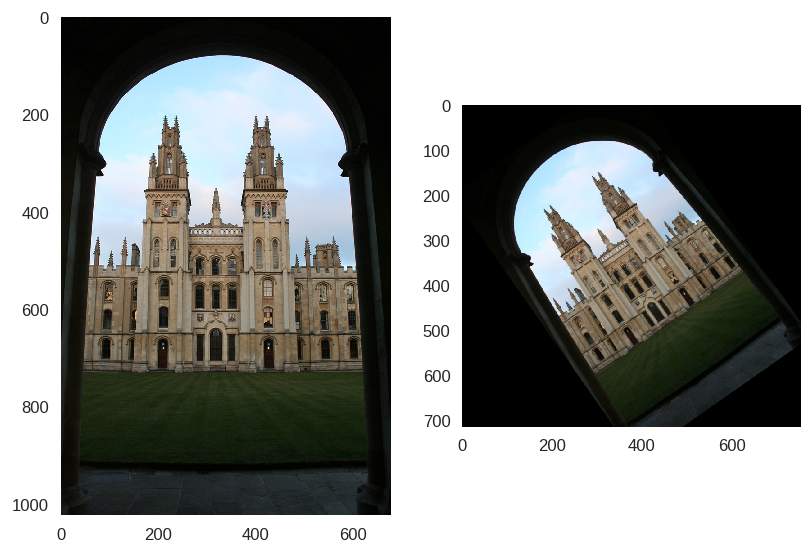

In [4]:
# Load an image
im1 = imread('data/oxbuild_lite/all_souls_000002.jpg')

# Let the second image be a rotated and scaled version of the first
im1prime = imresize(imrotate(np.pad(im1,((0,0),(200,200),(0,0)),'constant'),35,'bilinear'),0.7)

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im1)
ax2.imshow(im1prime)
plt.show()

A SIFT frame is a circle with an orientation and is specified by four parameters: the center $x$, $y$, the scale $s$, and the rotation $\theta$ (in radians), resulting in a vector of four parameters $(x, y, s, \theta)$.

Now compute and visualise the SIFT feature detections (frames):

In [0]:
def rgb2gray(rgb):
    return np.float32(np.dot(rgb[...,:3], [0.299, 0.587, 0.114])/255.0)

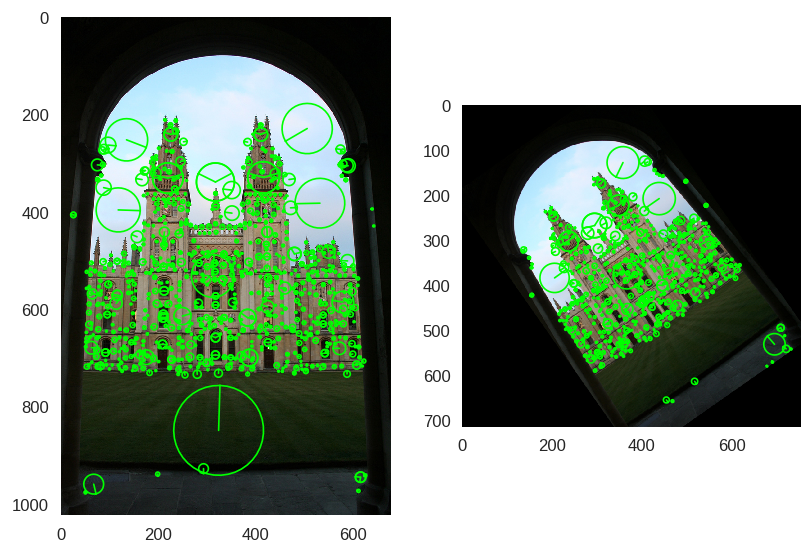

In [6]:
# Compute SIFT features for each

[frames1, descrs1] = cyvlfeat.sift.sift(rgb2gray(im1),peak_thresh=0.01)

[frames1prime, descrs1prime] = cyvlfeat.sift.sift(rgb2gray(im1prime),peak_thresh=0.01)

f, (ax1, ax2) = plt.subplots(1, 2)
plt.sca(ax1)
plt.imshow(im1)
plotframes(frames1,linewidth=1)

plt.sca(ax2)
plt.imshow(im1prime)
plotframes(frames1prime,linewidth=1)

plt.show()

Examine the second image and its rotated and scaled version and convince yourself that the detections overlap the same scene regions (even though the circles' positions have moved in the image and their radius' have changed). 
This demonstrates that the detection process (is co-variant or equi-variant) with translations, rotations and isotropic scalings. This class of transformations is known as a similarity or equiform.

### :: TASK 1.1 ::

Now repeat the exercise with a pair of natural images. 

Start by loading the second one: `data/oxbuild_lite/all_souls_000015.jpg`

Plot the images and feature frames. Again you should see that many of the detections overlap the same scene region. Note that, while repeatability occurs for the pair of natural views, it is much better for the synthetically rotated pair.

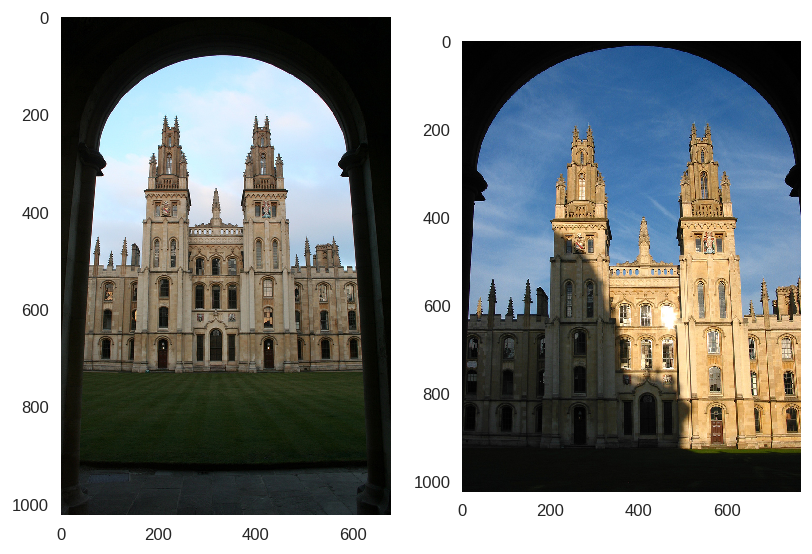

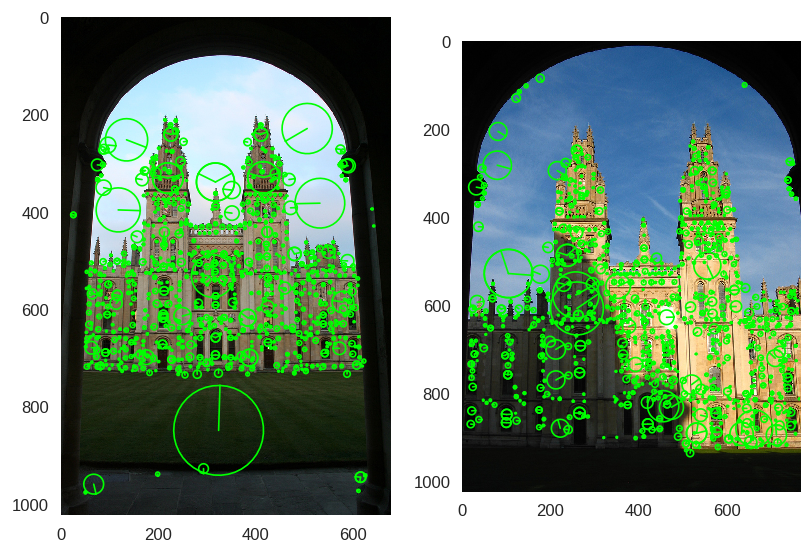

In [7]:
# Load an image
im2 = imread('data/oxbuild_lite/all_souls_000015.jpg')

# Let the second image be a rotated and scaled version of the first
im2prime = imresize(imrotate(np.pad(im1,((0,0),(200,200),(0,0)),'constant'),35,'bilinear'),0.7)

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(im1)
ax2.imshow(im2)
plt.show()

# Compute SIFT features for each

[frames1, descrs1] = cyvlfeat.sift.sift(rgb2gray(im1),peak_thresh=0.01)

[frames2, descrs2] = cyvlfeat.sift.sift(rgb2gray(im2),peak_thresh=0.01)

f, (ax1, ax2) = plt.subplots(1, 2)
plt.sca(ax1)
plt.imshow(im1)
plotframes(frames1,linewidth=1)

plt.sca(ax2)
plt.imshow(im2)
plotframes(frames2,linewidth=1)

plt.show()

The number of detected features can be controlled by changing the peakThreshold option. A larger value will select features that correspond to higher contrast structures in the image. 

### :: TASK 1.2 ::

***For the same image, produce 3 sub-figures with different values of peakThreshold. Comment.***

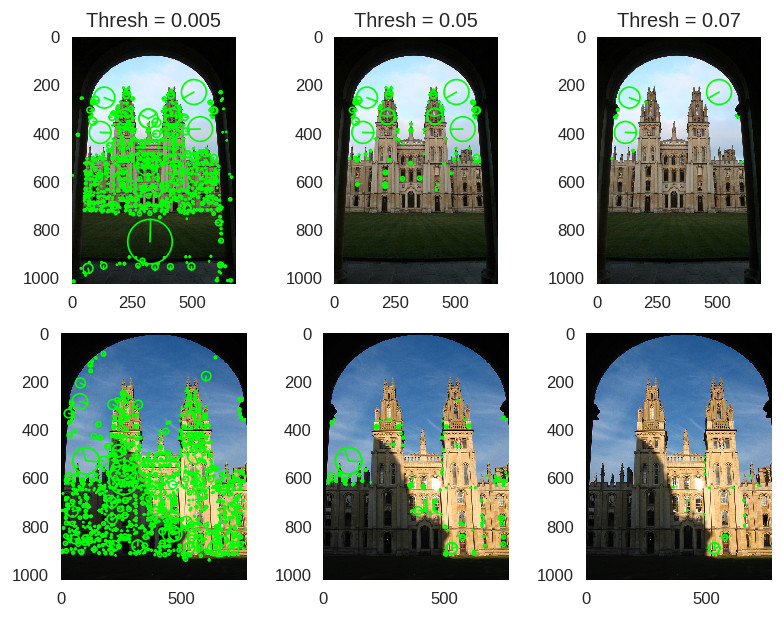

In [8]:
# Compute SIFT features for each

ax = {}

thresh = [0.005,0.05,0.07]

f, (ax[0], ax[1]) = plt.subplots(2, 3,figsize=(8,6))

#f, (ax[0], a) = plt.subplots(1, 3,figsize=(8,4))

for i in range(3):

  [frames1, descrs1] = cyvlfeat.sift.sift(rgb2gray(im1),peak_thresh=thresh[i])

  [frames2, descrs2] = cyvlfeat.sift.sift(rgb2gray(im2),peak_thresh=thresh[i])

  plt.sca(ax[0][i])
  plt.imshow(im1)
  plotframes(frames1,linewidth=1)
  
  plt.sca(ax[1][i])
  plt.imshow(im2)
  plotframes(frames2,linewidth=1)
  
  ax[0][i].set_title("Thresh = " + str(thresh[i]))

plt.show()

The higher the threshold, the bigger the required contrast to detect a feature. 
Let's denote $E_t$ the set of all detected feature for a given threshold $t$. It is clear that $\forall t<t', \ E_{t'} \subset E_t$. Therefore, choosing a small threshold allows SIFT to detect a lot of local features, but as we can see above if the threshold is too low we pick up on a lot of small contrasts that might not be representative of the object we are trying to detect and could be seen as noise.

On the other hand, choosing a big threshold forces SIFT to pick up only big contrasts that correspond to more global features. As we can see in the example above, big contrasts are not always representative of the desired object in the image, as the SIFT descriptors in both of the images on the right do not match

An ideal threshold should not be too big, so that it can detect enough features to represent the image correctly, and not too small, to prevent the algorithm on picking up on small "noisy" features.

## Feature point description and matching 

### Introduction to feature descriptors


The parameters $(t_x, t_y, s, \theta)$ of the detected *frames*,  can be used to extract a **scaled and oriented RGB patch** around $(t_x,t_y)$, used to *describe* the feature point.

The simplest possible descriptor would be to (i) resize these patches to a common size (eg. 30x30) and (ii) flatten to a vector. However, in practice we use more sophisticated descriptors such as SIFT, that is based on histograms of gradient orientations.

### :: TASK 1.3 ::


***What is the interest of using SIFT descriptors over these flattened RGB patches?***

Flattened RGB patches are not well adapted to represent 2 dimensional patches as the flattening affects the spacial coherence of the selected patch. In fact, any small change in a patch could drastically change the flattened version of the patch. Furthermore, SIFT descriptors allow for more general descriptions based on gradient orientations and their histograms, which are better adapted to give an idea of the local behavior of a patch, and being 128 dimensional they allow for a wide range of different local and more global descriptors. 

In the same sense, Convolutional NNs are more adapted for imaging problems than any NN who's inputs is a flattened version of the original image, altough convolutions and gradient histograms are 2 completely different objects.


### Descriptor matching
SIFT descriptors are 128-dimensional vectors, and can be directly *matched* to find correspondences between images. We will start with the simplest matching scheme (first nearest neighbour of descriptors in terms of Euclidean distance) and then add more sophisticated methods to eliminate any mismatches.

### :: TASK 1.4 ::


For each descriptor in im1, assign a matching descriptor in im2 by picking its first nearest neighbour.

Populate the second column of the matches vector.

In [0]:
[frames1, descrs1] = cyvlfeat.sift.sift(rgb2gray(im1),peak_thresh=0.01)

[frames2, descrs2] = cyvlfeat.sift.sift(rgb2gray(im2),peak_thresh=0.01)

#descrs1 = np.array(descrs1, dtype = float)
#descrs2 = np.array(descrs2, dtype = float)
descrs1 = descrs1.astype(float)
descrs2 = descrs2.astype(float)

# number of detections in image 1
N_frames1 = frames1.shape[0]
# allocate matrix for storing the matches
matches=np.zeros((N_frames1,2),dtype=np.int)
# the first column of the matrix are the indices on image 1: 0,1,2,....,N_frames1-1
matches[:,0]=range(N_frames1)


# write code to find the matches in image 2 of each feature in image 1 
# populate the second column of the matches vector

def Nearest_neighbour_loc(descrs1,descrs2):
  #initialize with first point
  loc = 0
  dist = np.linalg.norm(descrs1 - descrs2[loc,:])
  #iterate over all points of frame2 and replace if needed
  for i in range(descrs2.shape[0]):
    dist_i = np.linalg.norm(descrs1 - descrs2[i,:])
    if dist_i < dist:
      dist = dist_i
      loc = i
  return(loc)
  
for i in range(N_frames1):
  matches[i,1] = Nearest_neighbour_loc(descrs1[i,:],descrs2)
 
  


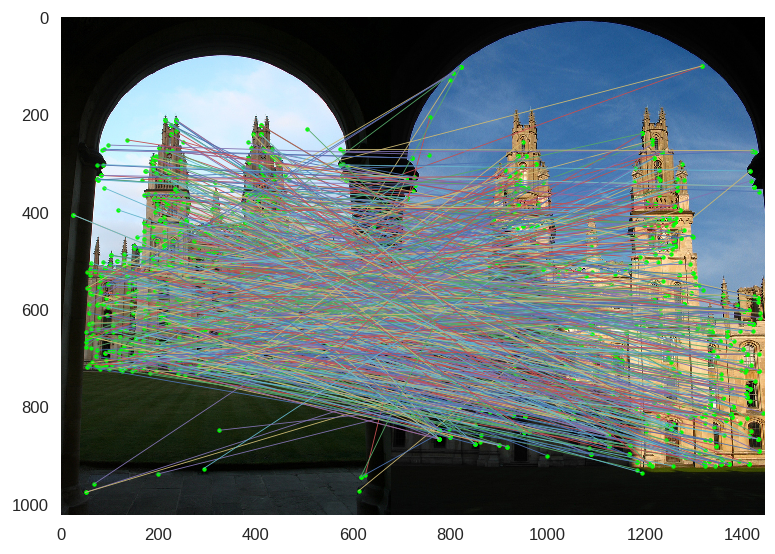

In [10]:
# plot matches
plt.imshow(np.concatenate((im1,im2),axis=1))
for i in range(N_frames1):
    j=matches[i,1]
    # plot dots at feature positions
    plt.gca().scatter([frames1[i,0],im1.shape[1]+frames2[j,0]], [frames1[i,1],frames2[j,1]], s=5, c=[0,1,0])
    # plot lines
    plt.plot([frames1[i,0],im1.shape[1]+frames2[j,0]],[frames1[i,1],frames2[j,1]],linewidth=0.5)
plt.show()

## Improving SIFT matching (i) using Lowe’s second nearest neighbour test


Lowe introduced a second nearest neighbour (2nd NN) test to identify, and hence remove, ambiguous matches. The idea is to identify distinctive matches by a threshold on the ratio of first to second NN distances.

The ratio is:  $$NN_{ratio} = \frac{1^{st}\text{NN distance}}{2^{nd}\text{NN distance}}.$$



### :: TASK 1.5 ::

***For each descriptor in im1, compute the ratio between the first and second nearest neighbour distances.***

***Populate the ratio vector.***


In [0]:
# allocate matrix for storing the matches
ratio=np.zeros((N_frames1,1))

# write code to find the 1st/2nd NN ratio for each descriptor in im1
# populate the ratio vector

def Nearest_neighbour_loc_dist(frame1,frames2):
  #initialize with first point
  loc = 0
  dist = np.linalg.norm(frame1 - frames2[loc,:])
  #iterate over all points of frame2 and replace if needed
  for i in range(frames2.shape[0]):
    dist_i = np.linalg.norm(frame1 - frames2[i,:])
    if dist_i < dist:
      dist = dist_i
      loc = i
  return(dist,loc)

for i in range(N_frames1):
  dist1,loc1 = Nearest_neighbour_loc_dist(descrs1[i,:],descrs2)
  dist2,loc2 = Nearest_neighbour_loc_dist(descrs1[i,:],np.delete(descrs2, (loc1), axis=0))
  ratio[i] = dist1/dist2 #Taking in account the fact that P(dist2=0)=0
  

The ratio vector will be now used to retain only the matches that are above a given threshold. 

A value of $NN_{threshold} = 0.8$ is often a good compromise between losing too many matches and rejecting mismatches.

In [0]:
NN_threshold=0.8

filtered_indices = np.flatnonzero(ratio<NN_threshold)
filtered_matches = matches[filtered_indices,:]

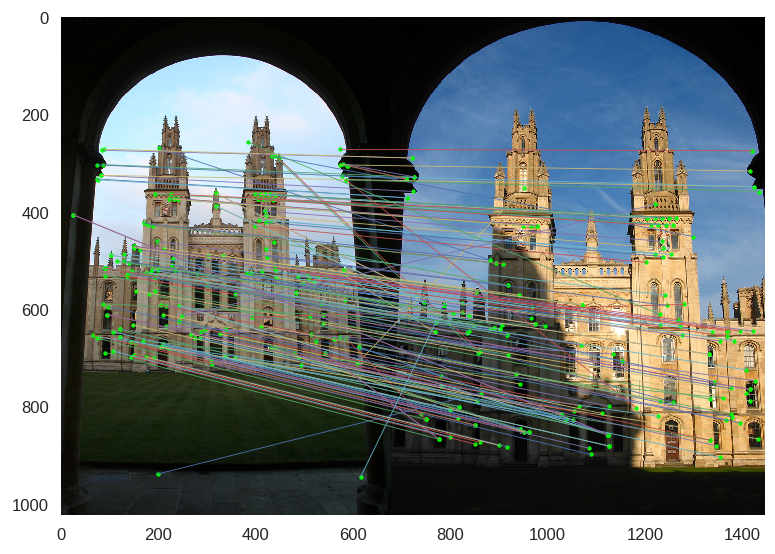

In [13]:
# plot matches
plt.imshow(np.concatenate((im1,im2),axis=1))
for idx in range(filtered_matches.shape[0]):
    i=filtered_matches[idx,0]
    j=filtered_matches[idx,1]
    # plot dots at feature positions
    plt.gca().scatter([frames1[i,0],im1.shape[1]+frames2[j,0]], [frames1[i,1],frames2[j,1]], s=5, c=[0,1,0]) 
    # plot lines
    plt.plot([frames1[i,0],im1.shape[1]+frames2[j,0]],[frames1[i,1],frames2[j,1]],linewidth=0.5)
plt.show()

## Improving SIFT matching (ii) by geometric verification

In addition to the 2nd NN test, we can also require consistency between the matches and a geometric transformation between the images. For the moment we will look for matches that are consistent with a similarity transformation:

$$\begin{bmatrix} x_2 \\ y_2 \end{bmatrix} = 
sR(\theta) \begin{bmatrix} x_1 \\ y_1 \end{bmatrix} + \begin{bmatrix} t_x \\ t_y \end{bmatrix} $$

which consists of a rotation by $\theta$, an isotropic scaling (i.e. same in all directions) by s, and a translation by a vector $(t_x, t_y)$. This transformation is specified by four parameters $(s,\theta,t_x,t_y)$ and can be computed from a single correspondence between SIFT detections in each image.

### :: TASK 1.6 ::

Given a detected feature with parameters $(x_1, y_1, s_1, \theta_1)$ in image $1$ matching a feature $(x_2, y_2, s_2, \theta_2)$ in image $2$, work out how to find out the parameters $(t_x,t_y,s,\theta)$ of the transformation mapping points from image $1$ to image $2$.




$$\theta=\theta_2 - \theta_1$$
$$s=\frac{s_2}{s_1}$$
$$\begin{bmatrix} t_x \\ t_y \end{bmatrix} =\begin{bmatrix}x_2 - s( x_1 \cos(\theta) - y_1 \sin(\theta)) \\y_2 - s( x_1 \sin(\theta) + y_1 \cos(\theta)) \end{bmatrix}$$


The matches consistent with a similarity can then be found using the RANSAC algorithm, described by the following steps:

For each tentative correspondence in turn:

* compute the similarity transformation;
* map all the SIFT detections in one image to the other using this transformation;
* accept matches that are within a threshold distance to the mapped detection (inliers);
* count the number of accepted matches;
* optionally, fit a more accurate affine transformation or homography to the accepted matches and test re-validate the matches.

Finally, choose the transformation with the highest count of inliers

After this algorithm the inliers are consistent with the transformation and are retained, and most mismatches should now be removed.

In [14]:
"""
#Silly me, I thought we had to code RANSAC ourselves, I'm leaving this here 
# in case it might come in handy later on

Nb_matches = np.zeros((N_frames1,1))

#for i in range(N_frames1):
#  dist1,loc1 = Nearest_neighbour_loc_dist(descrs1[i,:],descrs2)
#  dist2,loc2 = Nearest_neighbour_loc_dist(descrs1[i,:],np.delete(descrs2, (loc1), axis=0))
#  ratio[i] = dist1/dist2 #Taking in account the fact that P(dist2=0)=0
  
#NN_threshold=0.8

#filtered_indices = np.flatnonzero(ratio<NN_threshold)
#filtered_matches = matches[filtered_indices,:]

for i in range(N_frames1):
  params1 = frames1[i,:]
  params2 = frames2[Nearest_neighbour_loc(descrs1[i,:],descrs2),:]
  x1, y1, x2, y2 = params1[0], params1[1], params2[0], params2[1]
  theta, s = params2[3] - params1[3], params2[2]/params1[2]
  tx = x2 - s*(x1*np.cos(theta) - y1*np.sin(theta))
  ty = y2 - s*(x1*np.sin(theta) + y1*np.cos(theta))
  R_theta = [[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]]
  #frames1_transformed = np.zeros(frames1.shape[0],2)
  frames2_predicted_positions = s*np.dot(R_theta,frames1[i,:2]) + [tx,ty]
  for j in range(N_frames1):
    prediction = Nearest_neighbour_loc(descrs1[j,:],descrs2)
    if np.linalg.norm(prediction[:2]-frames2_predicted_positions)
  matches[i,1]
  """

"\n#Silly me, I thought we had to code RANSAC ourselves, I'm leaving this here \n# in case it might come in handy later on\n\nNb_matches = np.zeros((N_frames1,1))\n\n#for i in range(N_frames1):\n#  dist1,loc1 = Nearest_neighbour_loc_dist(descrs1[i,:],descrs2)\n#  dist2,loc2 = Nearest_neighbour_loc_dist(descrs1[i,:],np.delete(descrs2, (loc1), axis=0))\n#  ratio[i] = dist1/dist2 #Taking in account the fact that P(dist2=0)=0\n  \n#NN_threshold=0.8\n\n#filtered_indices = np.flatnonzero(ratio<NN_threshold)\n#filtered_matches = matches[filtered_indices,:]\n\nfor i in range(N_frames1):\n  params1 = frames1[i,:]\n  params2 = frames2[Nearest_neighbour_loc(descrs1[i,:],descrs2),:]\n  x1, y1, x2, y2 = params1[0], params1[1], params2[0], params2[1]\n  theta, s = params2[3] - params1[3], params2[2]/params1[2]\n  tx = x2 - s*(x1*np.cos(theta) - y1*np.sin(theta))\n  ty = y2 - s*(x1*np.sin(theta) + y1*np.cos(theta))\n  R_theta = [[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]]\n  #fram

### :: TASK 1.7 ::

In [0]:
def ransac(frames1,frames2,matches,N_iters=100,dist_thresh=15):
  # initialize
  max_inliers=0
  tnf=None
  # run random sampling
  for it in range(N_iters):
      # pick a random sample
      i = np.random.randint(0,frames1.shape[0])
      x_1,y_1,s_1,theta_1=frames1[i,:]
      j = matches[i,1]
      x_2,y_2,s_2,theta_2=frames2[j,:]
      
      # estimate transformation
      theta = theta_2 - theta_1
      s = s_2/s_1
      t_x = x_2 - s*(x_1*np.cos(theta) - y_1*np.sin(theta))
      t_y = y_2 - s*(x_1*np.sin(theta) + y_1*np.cos(theta))
      
      # evaluate estimated transformation
      X_1 = frames1[:,0]
      Y_1 = frames1[:,1]
      X_2 = frames2[matches[:,1],0]
      Y_2 = frames2[matches[:,1],1]
      
      X_1_prime = s*(X_1*np.cos(theta)-Y_1*np.sin(theta))+t_x
      Y_1_prime = s*(X_1*np.sin(theta)+Y_1*np.cos(theta))+t_y
      
      dist = np.sqrt((X_1_prime-X_2)**2+(Y_1_prime-Y_2)**2)
      
      inliers_indices = np.flatnonzero(dist<dist_thresh)
      num_of_inliers = len(inliers_indices)
      
      # keep if best
      if num_of_inliers>max_inliers:
        max_inliers=num_of_inliers
        best_inliers_indices = inliers_indices
        tnf = [t_x,t_y,s,theta]
        
  return (tnf,best_inliers_indices)
      

In [0]:
tnf,inliers_indices=ransac(frames1,frames2,matches)
filtered_matches = matches[inliers_indices,:]

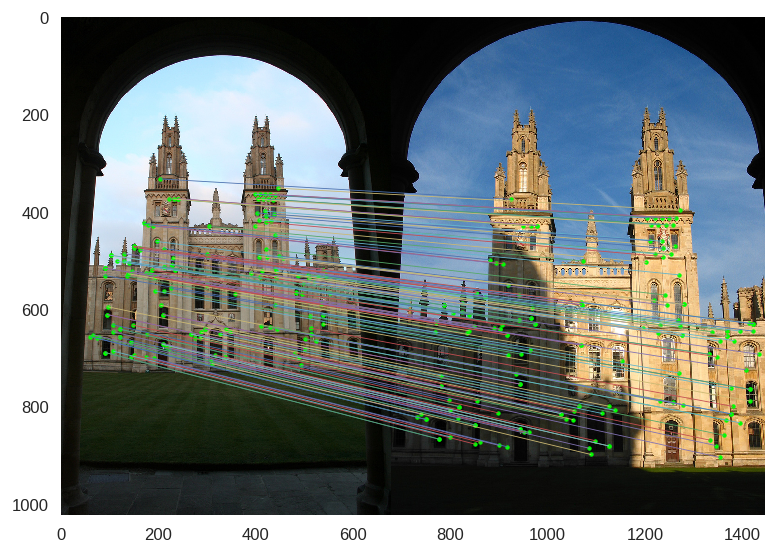

In [17]:
# plot matches filtered with RANSAC
plt.imshow(np.concatenate((im1,im2),axis=1))
for idx in range(filtered_matches.shape[0]):
    i=filtered_matches[idx,0]
    j=filtered_matches[idx,1]
    # plot dots at feature positions
    plt.gca().scatter([frames1[i,0],im1.shape[1]+frames2[j,0]], [frames1[i,1],frames2[j,1]], s=5, c=[0,1,0]) 
    # plot lines
    plt.plot([frames1[i,0],im1.shape[1]+frames2[j,0]],[frames1[i,1],frames2[j,1]],linewidth=0.5)
plt.show()

# Part 2: Compact descriptors for image retrieval

In large scale retrieval the goal is to match a query image to a large database of images (for example the WWW or Wikipedia). 

The quality of an image match is measured as the number of geometrically verified feature correspondences between the query and a database image. While the techniques discussed in Part 1 are sufficient to do this, in practice they require too much memory to store the SIFT descriptors for all the detections in all the database images.

In this part we will see how we can compute a *global* image descriptor from the set of SIFT descriptors using the bag-of-visual-words (BoVW) approach.

Then, we will see how these global descriptors can be used to rapidly retrieve a shortlist of candidate database images given a query image. Finally, we will see how to re-rank the shortlist of candidates using a geometric verification technique that requires only the *detector frames* and their assigned visual word indices; remember the SIFT descriptors are only used to compute the compact BoVW descriptors and then discarded.


## Download preprocessed dataset of paintings

In [18]:
print('downloading dictionary of SIFT features and precomputed BoVW descriptors for painting dataset...')
!wget -c http://www.di.ens.fr/willow/teaching/recvis/assignment1/paintings_imdb_SIFT_10k_preprocessed.mat
print('done!')

downloading dictionary of SIFT features and precomputed BoVW descriptors for painting dataset...
--2018-10-23 13:51:24--  http://www.di.ens.fr/willow/teaching/recvis/assignment1/paintings_imdb_SIFT_10k_preprocessed.mat
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/willow/teaching/recvis/assignment1/paintings_imdb_SIFT_10k_preprocessed.mat [following]
--2018-10-23 13:51:24--  https://www.di.ens.fr/willow/teaching/recvis/assignment1/paintings_imdb_SIFT_10k_preprocessed.mat
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

done!


## Load preprocessed dataset of paintings

We will now load the preprocessed dataset of paintings. The construction of this dataset has involved several steps.


1.   SIFT features were extracted from all painting in the dataset
2.   A global vocabulary of SIFT descriptors was computed using K-means clustering. These are the visual words of our dataset.
3.  The SIFT features for each painting were assigned to the nearest word, and a compact descriptor was generated for each painting. This compact descriptor consists in the normalized histogram of words. The histogram normalization itself involves 3 different steps:
    - a) TF-IDF weighting: each word is re-weighted according to its TF-IDF value. This removes weights to words that are very common and therefore not too descriptive.
    - b) Square-rooting: each element is square-rooted
    - c) L2-normalization: The whole histogram is L2-normalized.
    




In [19]:
imdb=loadmat('paintings_imdb_SIFT_10k_preprocessed.mat')

feature_vocab=np.transpose(imdb['vocab'])
imdb_hists=imdb['index']
imdb_tfidf=imdb['idf']

imdb_url = lambda idx: imdb['images'][0][0][3][0][idx].item()

num_words = feature_vocab.shape[0]
num_paintings = imdb_hists.shape[1]

print('The vocabulary of SIFT features contains %s  visual words' % num_words)
print('The dictionary index contains %s histograms corresponding to each painting in the dataset' % num_paintings)
print('The tdf-idf vector has shape '+str(imdb_tfidf.shape))

The vocabulary of SIFT features contains 10000  visual words
The dictionary index contains 1703 histograms corresponding to each painting in the dataset
The tdf-idf vector has shape (10000, 1)


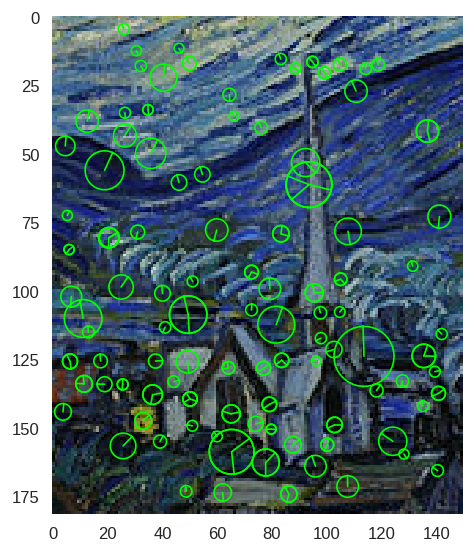

In [20]:
painting = imread('data/queries/mistery-painting1.jpg')

[frames, descrs] = cyvlfeat.sift.sift(rgb2gray(painting), peak_thresh=0.01)

plt.imshow(painting)
plotframes(frames,linewidth=1)

### :: TASK 2.1 ::

Construct a KDTree of the vocabulary for fast NN search. Then use the KDTree to find the closest word in the vocabulary to each descriptor of the query image.


In [0]:
from sklearn.neighbors import KDTree

tree = KDTree(feature_vocab)          
dist, ind = tree.query(descrs, k=1)    

### :: TASK 2.2 ::
Compute the compact BoVW descriptor of the query image.

In [0]:
query_hist=np.zeros((num_words,1))

for i in range(ind.size):
  query_hist[ind[i][0]] += 1

In [0]:
# process histogram
query_hist = query_hist*imdb_tfidf
query_hist = np.sqrt(query_hist)
query_hist = query_hist/np.linalg.norm(query_hist)


### :: TASK 2.3 ::

Compute the matching score with each image from the database.



In [0]:
scores = np.zeros((1,num_paintings))
for i in range(num_paintings):
  scores[:,i]=np.dot(query_hist.T,imdb_hists[:,i].toarray())

In [0]:
# sort in descending order
scores_sorted_idx = np.argsort(-scores)
scores_sorted = scores.ravel()[scores_sorted_idx]

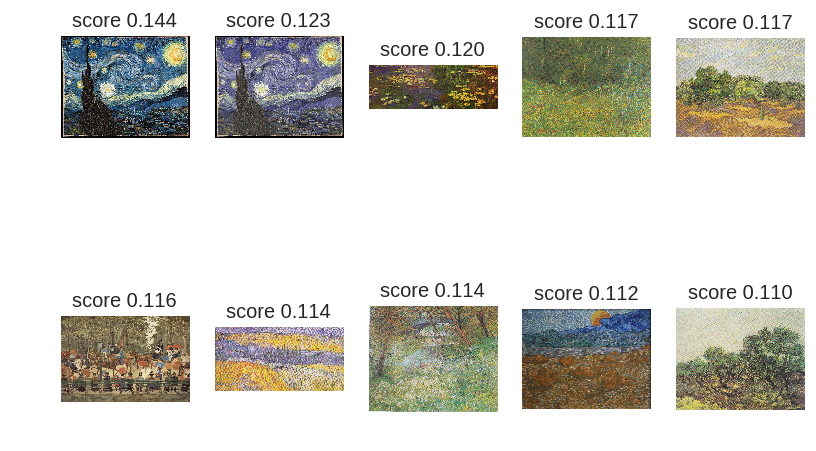

In [26]:
# plot top matches
N=10
top_N_idx = scores_sorted_idx.ravel()[:N]

for i in range(N):
  # download images
  url = imdb_url(top_N_idx[i])      
  with urlopen(url) as file:
      img = imread(file, mode='RGB')
  # choose subplot
  plt.subplot(int(np.ceil(N/5)),5,i+1)
  # plot
  plt.imshow(img)
  plt.axis('off')
  plt.title('score %1.3f' % scores_sorted.ravel()[i])
  

### The results are good, the 2 highest scores correspond to 2 matches. However, there isn't a clear difference between the good and the bad matches, as we can see in the plot below


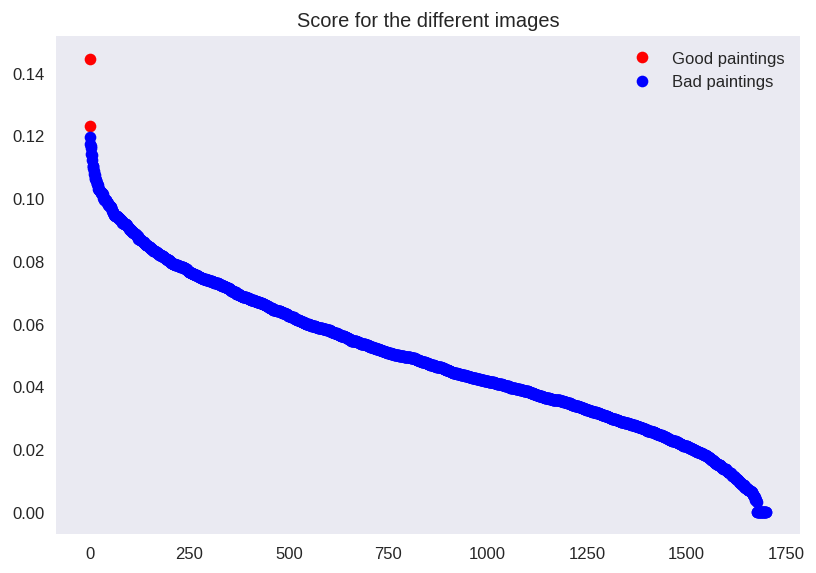

In [27]:
plt.plot(scores.ravel()[scores_sorted_idx.ravel()[:2]],"ro", label = "Good paintings")
plt.plot(scores.ravel()[scores_sorted_idx.ravel()[2:]],"bo", label = "Bad paintings")
plt.legend()
plt.title("Score for the different images")
plt.show()

### I have tried adding a score based on SIFT and geometric verification to ensure a clearer gap between the score of the mathcing images and the others :

In [28]:
# plot top matches
N=10
score_spatial = np.zeros(N)
score_sp_2 = np.zeros(N)
top_N_idx = scores_sorted_idx.ravel()[:N]

[frames, descrs] = cyvlfeat.sift.sift(rgb2gray(painting), peak_thresh=0.01)
N_frames = frames.shape[0]

for i in range(N):
  print("Image " + str(i+1))
  
  url = imdb_url(top_N_idx[i])      
  with urlopen(url) as file:
      img = imread(file, mode='RGB')
      
      
      
  
  # Compute SIFT features
  [frames_db, descrs_db] = cyvlfeat.sift.sift(rgb2gray(img),peak_thresh=0.01) 
  # allocate matrix for storing the matches
  matches=np.zeros((N_frames,2),dtype=np.int) 
  matches[:,0]=range(N_frames)
  for j in range(N_frames):
    matches[j,1] = Nearest_neighbour_loc(descrs[j,:],descrs_db)
  ratio=np.zeros((N_frames,1))
  for j in range(N_frames):
    dist1,loc1 = Nearest_neighbour_loc_dist(descrs1[j,:],descrs2)
    dist2,loc2 = Nearest_neighbour_loc_dist(descrs1[j,:],np.delete(descrs2, (loc1), axis=0))
    ratio[j] = dist1/dist2 #Taking in account the fact that P(dist2=0)=0
  NN_threshold=0.8
  filtered_indices = np.flatnonzero(ratio<NN_threshold)
  filtered_matches = matches[filtered_indices,:]
  tnf,inliers_indices=ransac(frames,frames_db,matches)
  filtered_matches = matches[inliers_indices,:]
  score_spatial[i] = len(filtered_matches)/float(frames_db.shape[0])
  score_sp_2[i] = len(filtered_matches)
  

Image 1
Image 2
Image 3
Image 4
Image 5
Image 6
Image 7
Image 8
Image 9
Image 10


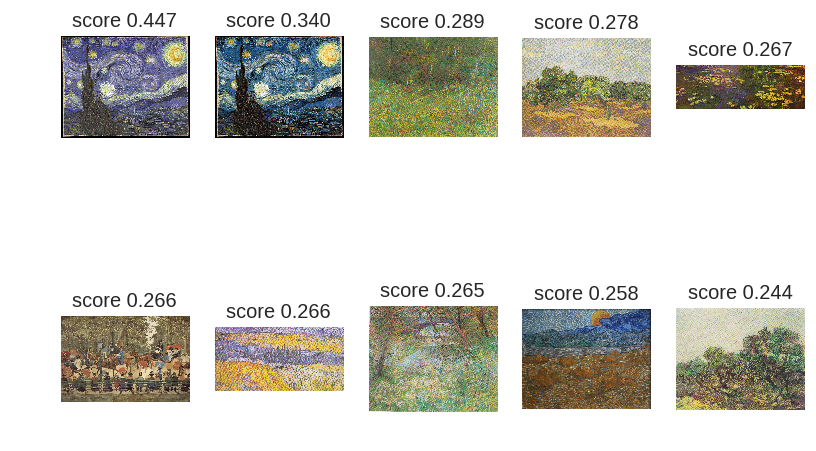

In [29]:
alpha = 0.2  ##This alpha allows us to have a balance between the compact descriptors scoring and the SIFT scoring
             ## setting it to 0 will give the scores as done previously, expect for the fact that those will have been normalized
score_spatial = score_sp_2/np.linalg.norm(score_sp_2)
scores_sorted_N = scores_sorted[0,:N]/np.linalg.norm(scores_sorted[0,:N])
final_scores = alpha*score_spatial + (1-alpha)*scores_sorted_N
final_scores_sorted_idx = np.argsort(-final_scores)
final_scores_sorted = final_scores.ravel()[final_scores_sorted_idx]

top_N_idx_2 = final_scores_sorted_idx.ravel()[:N]

for i in range(N):
  # download images
  url = imdb_url(top_N_idx[top_N_idx_2[i]])      
  with urlopen(url) as file:
      img = imread(file, mode='RGB')
  # choose subplot
  plt.subplot(int(np.ceil(N/5)),5,i+1)
  # plot
  plt.imshow(img)
  plt.axis('off')
  plt.title('score %1.3f' % final_scores_sorted.ravel()[i])

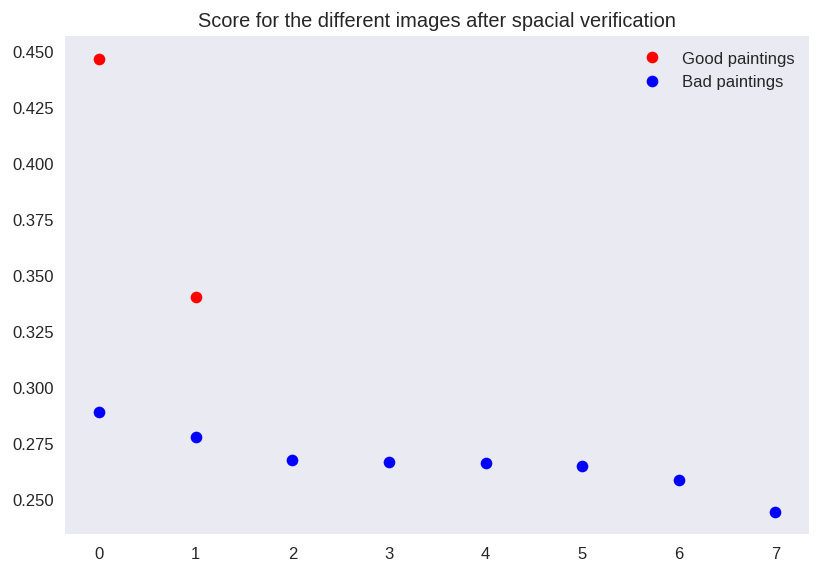

In [30]:
plt.plot(final_scores_sorted.ravel()[:2],"ro", label = "Good paintings")
plt.plot(final_scores_sorted.ravel()[2:],"bo", label = "Bad paintings")
plt.title("Score for the different images after spacial verification")
plt.legend()
plt.show()

There is a bigger gap between the 2 matches and the other images now, perhaps another choice of alpha would lead to better results. 

Since we are matching an image to only a part of another image, it isn't surprising either that this method doesn't bring drastical improvements as only a small part of the matching images will have matches.

Because of the fact that the desired matches contain the input image at a smaller scale, using the same SIFT descriptors threshold will not work well. Knowing this information, it would be wiser to use a lower SIFT descriptor threshold for the database images than for the input image as any frequency in the input image will be smaller in the output image.

## AUTHORSHIP STATEMENT

I declare that the preceding work was the sole result of my own effort and that I have not used any code or results from third-parties.

Louis VINCENT
